In [1]:
import pandas as pd
import numpy as np
import math, os, re, argparse, string
from matplotlib import pyplot as plt
from functools import partial
from operator import itemgetter
import string
from itertools import groupby
from functools import partial
from pathlib import Path
from tqdm import tqdm
tqdm.pandas()

import spacy

import torch
from torch.utils.data import Dataset
import torch.multiprocessing
from transformers import Trainer, TrainingArguments
from transformers import AutoModelForMaskedLM, AutoConfig, AutoTokenizer
from transformers import DataCollatorForLanguageModeling
import datasets, evaluate

import warnings
import pickle

from pathlib import Path
import jsonlines
import json


/home/hyohyeongjang/.local/lib/python3.9/site-packages/torch/cuda/__init__.py:619: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


In [2]:

class IOUtils():
    def __init__(self):
        pass
    
    @staticmethod
    def existsFile(file_url):
        
        import os
        from pathlib import Path

        if type(file_url) == str:
            url = Path(file_url).resolve()
        else:
            url = file_url.resolve()
        
        if url.exists():
            c = 1
            while True:
                if Path(str(url.parent) + "/" + str(url.stem) + f"_{c}" + str(url.suffix)).exists():
                    c += 1
                else:
                    break

            return Path(str(url.parent) + "/" + str(url.stem) + f"_{c}" + str(url.suffix))
        
        print(f"The url of the fIle to be saved is {url}")
        return url
    
    @staticmethod
    def recentFile(file_url):
        
        import os
        from pathlib import Path

        if type(file_url) == str:
            url = Path(file_url).resolve()
        else:
            url = file_url.resolve()

        if url.exists():
            c = 1
            while True:
                if Path(str(url.parent) + "/" + str(url.stem) + f"_{c}" + str(url.suffix)).exists():
                    c += 1
                else:
                    break
        else:
            c = 0
        if c == 0:
            return f"File not exists in {url}"

        if c == 1:
            print(f'The url of the fIle to be loaded is {Path(str(url.parent) + "/" + str(url.stem + str(url.suffix)))}')
            return Path(str(url.parent) + "/" + str(url.stem + str(url.suffix)))
        else:
            print(f'The url of the fIle to be loaded is {Path(str(url.parent) + "/" + str(url.stem + f"_{c-1}" + str(url.suffix)))}')
            return Path(str(url.parent) + "/" + str(url.stem + f"_{c-1}" + str(url.suffix)))

    @staticmethod
    def checkpoint_save(file_path, data, 
                        data_type = "dataFrame", 
                        file_type = "csv", 
                        index_dataFrame = False):
        import json

        save_path = IOUtils.existsFile(file_path)
        
        if data_type == "dataFrame" or data_type == "series":
            import pandas as pd

            if file_type == "csv":
                data.to_csv(save_path, index = index_dataFrame, encoding = 'utf-8')
                                
        
        if data_type == "list":
            if file_type == "txt":
                with open(save_path, "w", encoding = 'utf-8') as f:
                    for item in data:
                        f.write(item)
                        f.write("\n")

                
            if file_type == "jsonl":
                
                with open(save_path, "w", encoding = 'utf-8') as f:
                    for item in data.items():
                        f.write(json.dumps(item))
                        f.write("\n")

        
        if data_type == "dict":
            if file_type == "json":
                
                
                with open(save_path, "w", encoding="utf-8") as f:
                    json.dump(data, f, indent = "\t")
        
        return data # for the neatness of the code
    
    @staticmethod
    def checkpoint_load(file_path, 
                        data_type = "dataFrame", 
                        file_type = "csv"):
        load_path = IOUtils.recentFile(file_path)
        
        if data_type == "dataFrame" or data_type == "series":
            import pandas as pd

            if file_type == "csv":
                out = pd.read_csv(load_path)
                return out

        if data_type == "list":
            if file_type == "txt":
                out = None

                with open(load_path, "r", encoding = 'utf-8') as f:
                    out = [i.strip() for i in f.readlines()]
                return out

            if file_type == "jsonl":
                out = []

                with open(load_path, "r", encoding = 'utf-8') as f:
                    for line in f:
                        out.append(json.loads(line))

                return out

        
        if data_type == "dict":
            if file_type == "json":
                
                out = None
                
                with open(save_path, "w", encoding="utf-8") as f:
                    json.dump(data, f, indent = "\t")
                
                with open(load_path, "r") as f:
                    out = json.loads(f)
                
                return out
            


class ParallelizingUtils():
    
    import multiprocessing
    

    def __init__(self):
        self.type = None
        self.func = None
        
        pass
    
    
    def do_series(self, series, num_cores, pre_assign = False):

        from multiprocessing import Pool
        import numpy as np
        import pandas as pd

        if num_cores == 1: ##############somewhere error occurs
            if not pre_assign:
                return self._assign_map(series)
            else:
                return self.func(series)

        se_split = np.array_split(series, num_cores)
        pool = Pool(num_cores)
        if not pre_assign:
            df = pd.concat(pool.map(self._assign_map, se_split))
        else:
            df = pd.concat(pool.map(self.func, se_split))
        pool.close()
        pool.join()
        
        return df
    
    def _assign_map(self, serie):
        return serie.progress_map(self.func)
    
    def _assign_apply(self, df, axis):
        return df.progress_apply(self.func, axis = axis)

    def change_function(self, func):
        self.func = func

    def do_dataFrame(self, df, num_cores, axis = None, pre_assign = False):
        from multiprocessing import Pool
        import numpy as np
        import pandas as pd
        from functools import partial
        
        if num_cores == 1:
            if not pre_assign:
                if axis == None:
                    return valueError("axis needed")
                return self._assign_apply(df, axis = axis)
            else:
                return self.func(df)

        se_split = np.array_split(df, num_cores)
        pool = Pool(num_cores)
        if not pre_assign:
            
            if axis == None:
                    return valueError("axis needed")
            
            f = partial(self._assign_apply, axis = axis)
            df = pd.concat(pool.map(f, se_split))
            
        else:
            df = pd.concat(pool.map(self.func, se_split))
        pool.close()
        pool.join()
        
        return df


class CheckUtils():
    def __init__(self) -> None:
        pass
    
    # def checkValue(func):
    #     from functools import partial
    #     partial 
    @staticmethod
    def checkSeries(serdf, 
                 isNan = True, 
                 isEmpty = True, 
                 isInf = True,
                    isNotInstance = None,
                    isNotIn = False,
                    isNotInVal = None,
                    type = "row"
                 ):
        

        
        def _check_subsequent(x, 
                              isNotInstance = isNotInstance, 
                              isNan = isNan, 
                              isEmpty = isEmpty, 
                              isInf = isInf, 
                              isnotIn = isNotIn, 
                              isNotInVal = isNotInVal):
            out = False
            
            if isNotInstance is not None:
                x1 = (not isinstance(x, isNotInstance))
            else:
                x1 = False

            if isinstance(x, (int, float, complex)):
                x2 = pd.isna(x) if isNan else False
                x3 = math.isinf(x) if isInf else False
                x4 = False
            
            elif x == None:
                x2 = False
                x3 = False
                x4 = True if isEmpty else False
            
            else:
                x2 = False
                x3 = False
                x4 = (len(x) == 0) if isEmpty else False
                
            x5 = isNotInVal not in x if isNotIn else False

            return out | x1 | x2 | x3 | x4 | x5
        
        
        if isinstance(serdf, pd.Series):
            return serdf.progress_map(lambda x: _check_subsequent(x))
        
        elif isinstance(serdf, pd.DataFrame):
            out  = serdf.map(lambda x: _check_subsequent(x)) # cellwise
            if type == "row":
                return out.apply(lambda x: any(x), axis = 1)
            if type == "col":
                return out.apply(lambda x: any(x), axis = 0)
        
        else:
            raise ValueError("this is not either series or dataframe.")

    
    @staticmethod
    def isEmpty(dataframe) -> bool:
    
        if len(dataframe.index) == 0:
            return True
    
        return False

In [2]:
class Preprocessing():
    
    def __init__(self, spacy_args):
        
        self.parser = spacy.load(spacy_args)
    
    
    def preprocess_assign(self, inputs):
        return inputs.progress_map(self.preprocess)
    
    def preprocess(self, single_inputs):
        
        
    
        out = re.sub("'", "", single_inputs)
        out = re.sub(r'[^\w\s\d]', '' , out)
        out = re.sub(r"\s{2,}", " ", out)
        return out
    
    def process_assign(self, inputs):
        return inputs.progress_map(self.process)
    
    def process(self, single_inputs):
        return self.parser(single_inputs)
    
        
        

In [3]:
class Masking():
    
    def __init__(self):
        pass                        
        
        
    @staticmethod
    def extract_mask_assign(df_source, pure_dependency):
        return df_source.apply(lambda x: Masking.extract_mask(x['preprocessed'], x['spacy_processed'], pure_dependency), axis = 1)

    
    @staticmethod
    def extract_mask(original_input, parsed_input, pure_dependency):
        
        def _omit_subword(original_sentence, parsed_input):
            inputs = [x.text for x in parsed_input]
            original = original_sentence.split(" ")


            if len(original) == len(inputs):
                return torch.arange(len(parsed_input) , dtype = torch.int , requires_grad = False)
            
            else:

                index_original = 0
                index_inputs = 0
                sets = set()
                sets_fine = set()

                while True:
                    if index_inputs == len(inputs) or index_original == len(original):
                        break

                    else:
                        if original[index_original].startswith(inputs[index_inputs]):
                            sets_fine.add(index_original)
                            
                            index_original += 1
                            index_inputs += 1
                            
                        else:
                            sets.add(index_inputs)
                            sets.add(index_inputs - 1)

                            index_inputs += 1

                successive = [list(map(itemgetter(1), g)) for k, g in groupby(enumerate(list(sets)), lambda i: i[0]-i[1])]

                out_idx = sets_fine | set(s[0] for s in successive)
                
                return torch.tensor(list(out_idx), dtype = torch.int, requires_grad = False)
        
        try:
            root = [token for token in parsed_input if token.head == token][0]
            tokens = [token.text for token in parsed_input]
            zero_tensor =  torch.zeros(len(tokens), len(tokens), requires_grad=False)

            root_left = list(root.lefts)
            root_left = set(j for i in root_left for j in i.subtree)

            if not pure_dependency:
                lst = [[] for _ in range(len(tokens))] 
                for tokens_idx, token in enumerate(parsed_input):
                    if token in root_left:
                        if token.head == root:
                            lst[tokens_idx] = [t.i for t in list(token.subtree) + [token.head]]
                        else:
                            lst[tokens_idx] = [t.i for t in list(token.subtree) + [token.head]]
                    elif token == root:
                        lst[tokens_idx] = [t.i for t in list(token.subtree) + [token.head] if t not in root_left]

                    else:
                        lst[tokens_idx] = [t.i for t in list(token.subtree) + [token.head]]

            else:
                lst = [[t.i for t in list(token.subtree) + [token.head] ] for token in parsed_input]       


            for i, val in enumerate(lst):
                index = torch.tensor(val)
                zero_tensor[i].index_fill_(0, index, 1)


            output_idx = _omit_subword(original_input, parsed_input)


            return zero_tensor[output_idx][:,output_idx]
        
        except:
            return None
        
    
    
   
            
    @staticmethod
    def extend_mask_assign(df_source, tokenizer, max_length):
        
        return df_source.apply(lambda x: Masking._extend_mask(masking = x['spacy_masking'],                                                     
                                                       tokenizer = tokenizer,                                                     
                                                       original_sentence = x['preprocessed'],                                                     
                                                       max_length = max_length), axis = 1)
        
        
    @staticmethod
    def _extend_mask(masking, tokenizer, original_sentence, max_length):
        try:
            out = tokenizer.tokenize(original_sentence,                                
                                     padding="max_length",                     
                                     max_length=max_length, # sequence들을 max_length까지 패딩                     
                                     return_tensors="pt")
            out_without_pad = [i for i in out if i != "[PAD]"]
            pad_len = len(out) - len(out_without_pad)


            is_initial = [0 if i.startswith("##") else 1 for i in out_without_pad]
            cum_is_initial = [sum(is_initial[:i+1])-1  for i in range(len(out_without_pad))]


            subword_mask = torch.tensor([[int(masking[i][j].item()) for j in cum_is_initial] for i in cum_is_initial], requires_grad = False)
            pad_zeros = torch.zeros(len(out_without_pad), pad_len, requires_grad = False)

            out = torch.cat((subword_mask, pad_zeros), dim = -1)
            out.requires_grad = False
            zeros = torch.zeros((max_length - out.size()[0], max_length), requires_grad = False)
            out = torch.cat([out, zeros], dim = 0)

            return out
        
        except:
            return None
        


In [4]:

class DatasetProducer():
    def __init__(self):
        self.train_data = None
        self.eval_data = None
        self.test_data = None
        
        self.train_dataset = None
        self.eval_dataset = None
        self.test_dataset = None
            
    def load_dataset(self):
        
        
        nli_data = datasets.load_dataset("nyu-mll/multi_nli")

        train_dataset = pd.Series(nli_data['train']['premise'])
        valid_dataset = pd.Series(nli_data['validation_matched']['premise'])
        test_dataset = pd.Series(nli_data['validation_mismatched']['premise'])

        train_dataset = train_dataset[train_dataset.map(lambda x: 30 < len(x) < 500)]
        valid_dataset = valid_dataset[valid_dataset.map(lambda x: 30 < len(x) < 500)]
        test_dataset = test_dataset[test_dataset.map(lambda x: 30 < len(x) < 500)]

        train_dataset = train_dataset[CheckUtils.checkSeries(train_dataset, 
                                isNan = True,
                                 isEmpty = True,
                                 isInf = False,
                                 isNotInstance = str).map(lambda x: not x)].reset_index(drop = True)
        valid_dataset = valid_dataset[CheckUtils.checkSeries(valid_dataset, 
                                isNan = True,
                                 isEmpty = True,
                                 isInf = False,
                                 isNotInstance = str).map(lambda x: not x)].reset_index(drop = True)
        test_dataset = test_dataset[CheckUtils.checkSeries(test_dataset, 
                                isNan = True,
                                 isEmpty = True,
                                 isInf = False,
                                 isNotInstance = str).map(lambda x: not x)].reset_index(drop = True)

        return train_dataset, valid_dataset, test_dataset
    
    def load_data_with_custom_mask(self, *,
                               dataset, 
                               slice_len,    
                               start_len,
                               max_length = 128,  
                               num_cores = 2,
                               spacy_model = 'en_core_web_sm',    
                               tokenizer = "google-bert/bert-base-uncased",
                               multiprocessing = True,
                                
                               
                              ):

        warnings.filterwarnings('ignore')
        torch.multiprocessing.set_sharing_strategy('file_system')

        if multiprocessing == False:
            pass
        else:
            os.environ["TOKENIZERS_PARALLELISM"] = "false"
        
        
        processor = Preprocessing(spacy_model)
        multiprocessor = ParallelizingUtils()

        tokenizer = AutoTokenizer.from_pretrained("google-bert/bert-base-uncased")

        print('loading_data...')
        if slice_len is not None:
            data = dataset[start_len:slice_len]
        else:
            data = dataset[start_len:]

        print("tokenizinig_prefiltering...")

        filters = data.progress_map(lambda x: tokenizer.tokenize(x, padding = "max_length", max_length = max_length)[-1] == "[PAD]")
        data = data[filters].reset_index(drop = True)


        print("preprocessing...")
        multiprocessor.change_function(processor.preprocess_assign)
        preprocessed_data_out = multiprocessor.do_series(data, num_cores = num_cores, pre_assign = True)
        filters = CheckUtils.checkSeries(preprocessed_data_out,                                                       
                                         isNan = True,                                                              
                                         isEmpty = True,                                                              
                                         isInf = False,                                                              
                                         isNotInstance = None).map(lambda x: not x)
        data = preprocessed_data_out[filters].reset_index(drop = True) # preprocessed
        data.name = 'preprocessed'

        print("spacy_parsing...")
        multiprocessor.change_function(processor.process_assign)
        spacy_processed_out = multiprocessor.do_series(data, num_cores = num_cores, pre_assign = True)
        spacy_processed_out.name = "spacy_processed"
        data = pd.concat([data, spacy_processed_out], axis = 1) # preprocessed, spacy_processed
        filters = CheckUtils.checkSeries(spacy_processed_out,                                                       
                                         isNan = True,                                                              
                                         isEmpty = True,                                                              
                                         isInf = False,                                                              
                                         isNotInstance = None).map(lambda x: not x)
        data = data[filters].reset_index(drop = True)



        print("extracting spacy attention mask...")
        multiprocessor.change_function(partial(Masking.extract_mask_assign, pure_dependency = True))
        mask_out = multiprocessor.do_dataFrame(data, num_cores = num_cores, pre_assign = True)
        mask_out.name = 'spacy_masking'
        data = pd.concat([data, mask_out], axis = 1) # preprocessed, spacy_processed, masking
        filters = CheckUtils.checkSeries(mask_out,                                                       
                                         isNan = True,                                                              
                                         isEmpty = True,                                                              
                                         isInf = False,                                                              
                                         isNotInstance = None).map(lambda x: not x)
        data = data[filters].reset_index(drop = True)


        print("expanding spacy attention mask to bert mask...")
        multiprocessor.change_function(partial(Masking.extend_mask_assign, tokenizer = tokenizer, max_length = max_length))
        subword_masking = multiprocessor.do_dataFrame(data, num_cores = num_cores, pre_assign = True)
        subword_masking.name = 'encoder_attention_mask'
        data = pd.concat([data, subword_masking], axis = 1) # preprocessed, spacy_processed, masking, subword_masking
        filters = CheckUtils.checkSeries(subword_masking,                                                       
                                         isNan = True,                                                              
                                         isEmpty = True,                                                              
                                         isInf = False,                                                              
                                         isNotInstance = None).map(lambda x: not x)
        data = data[filters].reset_index(drop = True)

        return data[['preprocessed', 'encoder_attention_mask']]

In [8]:


class DatasetWithCustomMasking(Dataset):
    def __init__(self, data, tokenizer, *,  data_args, mask_args, tokenizer_config = None):
        
        self.data = list(data[data_args])        
        self.masking = list(data[mask_args])
        self.tokenizer = tokenizer
        
        if tokenizer_config is not None:
            self.padding = tokenizer_config['padding']
            self.max_length = tokenizer_config['max_length']
            self.return_tensors = tokenizer_config['return_tensors']
            self.return_special_tokens_mask =  tokenizer_config['return_special_tokens_mask']
            
        
    def __len__(self):
        
        return len(self.data) 
    
    def __getitem__(self, idx):
        data = self.data[idx]
        encoded = self.tokenizer(data,                         
                         padding = self.padding,                        
                         max_length = self.max_length,
                         return_tensors = self.return_tensors,
                         return_special_tokens_mask = self.return_special_tokens_mask
                                 
                                )
        encoded.pop('token_type_ids')
        encoded = {key: encoded[key].view(-1) for key in encoded}
        
        masking = self.masking[idx]
        encoded['attention_mask'] = masking
        
        return encoded


class TrainingFunctools():
    def __init__(self):
        pass
    
    @staticmethod
    def metric(eval_pred, func):
        predictions, labels = eval_pred
        predictions = np.argmax(predictions, axis = -1) # (batch, sequence lenagh, hidden_state)
        filters = labels != -100

        predictions = predictions[filters]
        labels = labels[filters]
        return func.compute(predictions = predictions, references = labels)

    def setTrainer(*, 
          model,
          tokenizer,
          train_dataset,
          eval_dataset,
          data_collator,      
          output_dir,
          do_eval,
          compute_metrics = metric,
          eval_steps,
          save_steps,
          save_total_limit,
          load_best_model_at_end,
          save_evaluation_strategy,
          metric_for_best_model,
          greater_is_better,
          num_epoch,
          seed):
        
        args = TrainingArguments(do_train = True,    
                         output_dir = output_dir,                         
                         do_eval = do_eval,                        
                         evaluation_strategy = save_evaluation_strategy, # necessary: change to step
                         eval_steps = eval_steps, # necessary: set step
                         save_steps = save_steps,
                         save_strategy = save_evaluation_strategy,                         
                         save_total_limit = save_total_limit,
                         load_best_model_at_end = load_best_model_at_end, # necessary: EarlyStoppingCallBack하려면 True여야 함
                         metric_for_best_model = metric_for_best_model,
                         greater_is_better = greater_is_better, # necessary: higher metric results better performance # default = True when metric_for_best_model is set
                         num_train_epochs = num_epoch,
                         seed = seed,
                         per_device_train_batch_size = 32,
                         per_device_eval_batch_size = 32,
                         learning_rate = 1e-6,
                         weight_decay = 0.0001
                             
                            )

        trainer = Trainer(model = model,
                          args= args,
                          train_dataset = train_dataset,
                          eval_dataset = eval_dataset,
                          tokenizer = tokenizer,
                          data_collator = data_collator,
                          compute_metrics = compute_metrics,
                         )

        return trainer


In [9]:
dataloader_config = {"shuffle": True, "batch_size": 32}
tokenizer_config = {'padding': 'max_length', "max_length": 128, 'truncation' : True, 'return_tensors' : 'pt', 'return_special_tokens_mask': True}
optimizer_config = {'type': 'adam', 'lr': 1e-6, "weight_decay": 0.001, 'eps' : 1e-08} # default except learning rate(1e-3)
loss_config = {'type': 'crossEntropyLoss'}

def save_data(*,
         dataset = None,
         load_dataset = False,
         trainer_start_len = None,
         trainer_slice_len = None,
         eval_slice_len = None,
         test_slice_len = None,
         num_cores = 40,
         model_name = "google-bert/bert-base-uncased",
         dataloader_config = dataloader_config,
         tokenizer_config = tokenizer_config,
         optimizer_config = optimizer_config,
         loss_config =loss_config,
         checkpoint_output = "./checkpoint_output",
         
        ):
    
    
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModelForMaskedLM.from_config(config = AutoConfig.from_pretrained(model_name))

    
    data = DatasetProducer()
    data.train_data, data.eval_data, data.test_data = data.load_dataset()
    data.train_data = data.load_data_with_custom_mask(dataset = data.train_data, 
                                                 slice_len = trainer_slice_len, 
                                                 start_len = trainer_start_len,
                                                 num_cores = num_cores)  
    with open(f"train_data_{trainer_slice_len}", "wb") as fw:
        pickle.dump(data.train_data, fw)
    

    
    data.eval_data = data.load_data_with_custom_mask(dataset = data.eval_data, 
                                                slice_len = eval_slice_len, 
                                                num_cores = num_cores)
    data.test_data = load_data_with_custom_mask(dataset = data.test_data, 
                                                slice_len = test_slice_len, 
                                                num_cores = num_cores)

    
    with open("eval_data", "wb") as fw:
        pickle.dump(data.eval_data, fw)
        
#     data.train_dataset = DatasetWithCustomMasking(data.train_data, tokenizer,                          
#                                              data_args = 'preprocessed',                          
#                                              mask_args = "encoder_attention_mask",                       
#                                              tokenizer_config = tokenizer_config)
#     data.eval_dataset = DatasetWithCustomMasking(data.eval_data, tokenizer, 
#                                             data_args = 'preprocessed',                                                   
#                                             mask_args = "encoder_attention_mask",                                                
#                                             tokenizer_config = tokenizer_config)
# # #     data.test_dataset = DatasetWithCustomMasking(data.test_dataset, tokenizer, 
# # #                                             data_args = 'preprocessed',                                                   
# # #                                             mask_args = "encoder_attention_mask",                                                
# # #                                             tokenizer_config = tokenizer_config)
    
    
#     data_collator = DataCollatorForLanguageModeling(tokenizer=tokenizer, mlm=True, mlm_probability=0.15)
#     accuracy = evaluate.load('accuracy')
    
#     output_dir = str(Path(checkpoint_output).resolve())
    
#     trainer = TrainingFunctools.setTrainer(model = model,     
#                     tokenizer = tokenizer,     
#                     train_dataset = data.train_dataset,   
#                     compute_metrics = partial(TrainingFunctools.metric, func = accuracy), 
#                     do_eval = True,     
#                     output_dir = output_dir,
#                     eval_steps = 1,    
#                     save_steps = 1,
#                     save_total_limit = 3,                
#                     load_best_model_at_end = True,                
#                     save_evaluation_strategy = "steps",                
#                     metric_for_best_model = "eval_accuracy",    
#                     greater_is_better = True,
#                     train_batch_size = 32,                
#                     eval_batch_size = 32,                
#                     num_epoch = 20,                
#                     seed = 42,
#                     eval_dataset = data.eval_dataset,     
#                     data_collator = data_collator,    
#                     save_only_model = True
#                    )

#     trainer.train()
    
    





In [10]:
def fill_tensor(tensor1, tensor2, index):
    t = torch.tensor(tensor1, requires_grad = False)
    t[...,:index,:index] = tensor2
    return t

def append_random_attention(df, tokenizer, tokenizer_config):
    
    
    padding = tokenizer_config['padding']
    max_length = tokenizer_config['max_length']
    return_tensors  = tokenizer_config['return_tensors']
    df_sentence = df['preprocessed']
    
    df_len = df_sentence.progress_map(lambda x: len(tokenizer.tokenize(x)))
    df_len.name = "real_token_length"
    df_whole = df_len.progress_map(lambda x: x ** 2)
    
    df_temp = pd.concat([df['encoder_attention_mask'].copy(), df_len], axis = 1)
    df_ones = df_temp.progress_apply(lambda x: x['encoder_attention_mask'][:x['real_token_length']][:x['real_token_length']].sum(), axis = 1)
    
    probs = df_ones.sum() / df_whole.sum()
    
    df_random_attention = df_len.progress_map(lambda x: torch.bernoulli(torch.full((x,x), probs)) )
    df_random_attention.name = "real"
    df_attention_whole = df_len.progress_map(lambda x: torch.zeros(max_length, max_length))
    df_attention_whole.name = "whole"
    
    df_attention = pd.concat([df_random_attention, df_attention_whole, df_len], axis = 1)
    out = df_attention.progress_apply(lambda x: fill_tensor(x['whole'], x['real'], x['real_token_length']), axis = 1)
    out.name = "encoder_attention_mask"
    
    return pd.concat([df_sentence, out], axis = 1)
    
    
    
    

In [12]:
dataloader_config = {"shuffle": True, "batch_size": 32}
tokenizer_config = {'padding': 'max_length', "max_length": 128, 'truncation' : True, 'return_tensors' : 'pt', 'return_special_tokens_mask': True}
optimizer_config = {'type': 'adam', 'lr': 1e-6, "weight_decay": 0.001, 'eps' : 1e-08} # default except learning rate(1e-3)
loss_config = {'type': 'crossEntropyLoss'}

def main(*,
         dataset = None,
         load_dataset = False,
         trainer_start_len = None,
         trainer_slice_len = None,
         eval_slice_len = None,
         eval_start_len = None,
         test_slice_len = None,
         num_cores = 20,
         model_name = "google-bert/bert-base-uncased",
         dataloader_config = dataloader_config,
         tokenizer_config = tokenizer_config,
         optimizer_config = optimizer_config,
         loss_config =loss_config,
         checkpoint_output = "./checkpoint_output_{}",
         train_type 
         
        ):
    
    
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModelForMaskedLM.from_config(config = AutoConfig.from_pretrained(model_name))
    checkpoint_output = checkpoint_output.format(train_type)
    print(checkpoint_output)
    
    data = DatasetProducer()
#     data.train_data, data.eval_data, data.test_data = data.load_dataset()
# #     data.train_data = data.load_data_with_custom_mask(dataset = data.train_data, 
# #                                                  slice_len = trainer_slice_len, 
# #                                                  start_len = trainer_start_len,
# #                                                  num_cores = num_cores)  
# #     with open(f"train_data_{trainer_slice_len}", "wb") as fw:
# #         pickle.dump(data.train_data, fw)
    

    
#     data.eval_data = data.load_data_with_custom_mask(dataset = data.eval_data, 
#                                                 slice_len = eval_slice_len, 
#                                                 start_len = eval_start_len,
#                                                 num_cores = num_cores)
#     with open("eval_data", "wb") as fw:
#         pickle.dump(data.eval_data, fw)
        
#     data.test_data = load_data_with_custom_mask(dataset = data.test_data, 
#                                                 slice_len = test_slice_len, 
#                                                 num_cores = num_cores)

    data_pickle = []
    for i in range(20000, 360000, 20000):
        with open(f"train_data/train_data_{i}", "rb") as fr:
            print(f"load {i}-th data pickles")
            data_pickle.append(pickle.load(fr))

    
    
    data.train_data = pd.concat(data_pickle, axis = 0)
    
    
    with open(f"eval_data/eval_data", "rb") as fr:
        data.eval_data = pickle.load(fr)

    print(len(data.train_data), len(data.eval_data))
   
    if train_type == "dependency":
        pass
    
    if train_type == "random":
        data.train_data = append_random_attention(data.train_data, tokenizer, tokenizer_config)
        data.eval_data = append_random_attention(data.eval_data, tokenizer, tokenizer_config)
    
    
        
    data.train_dataset = DatasetWithCustomMasking(data.train_data, tokenizer,                          
                                             data_args = 'preprocessed',                          
                                             mask_args = "encoder_attention_mask",                       
                                             tokenizer_config = tokenizer_config)
    data.eval_dataset = DatasetWithCustomMasking(data.eval_data, tokenizer, 
                                            data_args = 'preprocessed',                                                   
                                            mask_args = "encoder_attention_mask",                                                
                                            tokenizer_config = tokenizer_config)
# #     data.test_dataset = DatasetWithCustomMasking(data.test_dataset, tokenizer, 
# #                                             data_args = 'preprocessed',                                                   
# #                                             mask_args = "encoder_attention_mask",                                                
# #                                             tokenizer_config = tokenizer_config)
    

#     append_random_attention(data.train_dataset)
#     append_random_attention(data.eval_dataset)
    
    data_collator = DataCollatorForLanguageModeling(tokenizer=tokenizer, mlm=True, mlm_probability=0.15)
    accuracy = evaluate.load('accuracy')
    
    output_dir = str(Path(checkpoint_output).resolve())
    
    trainer = TrainingFunctools.setTrainer(model = model,     
                    tokenizer = tokenizer,     
                    train_dataset = data.train_dataset,   
                    compute_metrics = partial(TrainingFunctools.metric, func = accuracy), 
                    do_eval = True,     
                    output_dir = output_dir,
                    eval_steps = 500,    
                    save_steps = 500,
                    save_total_limit = 3,                
                    load_best_model_at_end = True,                
                    save_evaluation_strategy = "steps",                
                    metric_for_best_model = "eval_accuracy",    
                    greater_is_better = True,              
                    num_epoch = 200,                
                    seed = 42,
                    eval_dataset = data.eval_dataset,     
                    data_collator = data_collator,    
                   )

    trainer.train()
    
    


In [15]:

if __name__ == "__main__":



    # parser = argparse.ArgumentParser()

#     parser.add_argument('--num', default = None, type = int)
#     parser.add_argument('--startnum', default = None, type = int)

    # parser.add_argument('--train_type', default="dependency", type=str, required=True, help='Count of derivatives.')
#    # parser.add_argument('--lexicon', default=None, type=str, required=True, help='Lexicon setting')
#    # parser.add_argument('--mode', default=None, type=str, required=True, help='Affix type.')
#    # parser.add_argument('--batch_size', default=None, type=int, required=True, help='Batch size.')
#    # parser.add_argument('--lr', default=None, type=float, required=True, help='Learning rate.')
#    # parser.add_argument('--n_epochs', default=None, type=int, required=True, help='Number of epochs.')
#    # parser.add_argument('--cuda', default=None, type=int, required=True, help='Selected CUDA.')
#    # parser.add_argument('--freeze', default=False, action='store_true', help='Freeze BERT parameters.')
#    # parser.add_argument('--inpath', default=None, type=str, required=True, help='Count of derivatives.')
#    # parser.add_argument('--data', default=None, type=str, required=True, help='Count of derivatives.')

    # args = parser.parse_args()
    import os
    os.environ["TOKENIZERS_PARALLELISM"] = "false"

    
#     out = main(trainer_start_len = args.startnum,
#               trainer_slice_len = args.num)
    # td, ed = main(num_cores = 1, train_type = args.train_type)
    ed = main(num_cores = 1, train_type = "dependency")

#     out = load_data()

/home/hyohyeongjang/.local/lib/python3.9/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


./checkpoint_output_dependency


In [16]:
ed

,preprocessed,encoder_attention_mask
0,This site includes a list of all award winners...,"[[tensor(1.), tensor(1.), tensor(0.), tensor(0..."
1,uh i dont know i i have mixed emotions about h...,"[[tensor(1.), tensor(0.), tensor(0.), tensor(0..."
2,yeah i i think my favorite restaurant is alway...,"[[tensor(1.), tensor(1.), tensor(0.), tensor(0..."
3,i dont know um do you do a lot of camping,"[[tensor(1.), tensor(0.), tensor(0.), tensor(0..."
4,well that would be a help i wish they would do...,"[[tensor(1.), tensor(0.), tensor(0.), tensor(1..."
...,...,...
8682,Since 1998 LSC has initiated and overseen sign...,"[[tensor(1.), tensor(0.), tensor(0.), tensor(0..."
8683,Eighty percent of pagers in the United States ...,"[[tensor(1.), tensor(1.), tensor(0.), tensor(0..."
8684,Finally the FDA will conduct workshops issue g...,"[[tensor(1.), tensor(0.), tensor(0.), tensor(0..."
8685,Cirque du Soleils The latest from the acclaime...,"[[tensor(1.), tensor(1.), tensor(1.), tensor(1..."


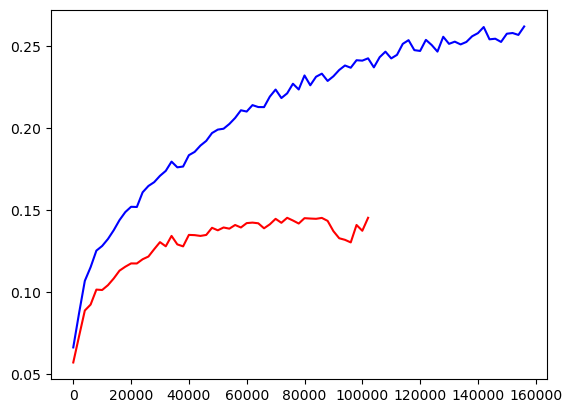

In [48]:
from matplotlib import pyplot as plt
import json
with open("checkpoint_output_dependency/checkpoint-dependency-high/trainer_state.json", "r") as f:
    x = json.load(f)
dependency_accuracy = [i for i in [i.get('eval_accuracy') for i in x['log_history']] if i != None]
with open("checkpoint_output_random/checkpoint-random-high/trainer_state.json", "r") as f:
    x = json.load(f)
random_accuracy = [i for i in [i.get('eval_accuracy') for i in x['log_history']] if i != None]

plt.plot(range(0, 2000 * len(dependency_accuracy), 2000), dependency_accuracy, c = "b")
plt.plot(range(0, 2000 * len(random_accuracy), 2000), random_accuracy, c = "r")
plt.show()

In [13]:
   
# parser = argparse.ArgumentParser()

# parser.add_argument('--do_train', default = False, action='store_true')

# # parser.add_argument('--count', default=None, type=int, required=True, help='Count of derivatives.')
# # parser.add_argument('--lexicon', default=None, type=str, required=True, help='Lexicon setting')
# # parser.add_argument('--mode', default=None, type=str, required=True, help='Affix type.')
# # parser.add_argument('--batch_size', default=None, type=int, required=True, help='Batch size.')
# # parser.add_argument('--lr', default=None, type=float, required=True, help='Learning rate.')
# # parser.add_argument('--n_epochs', default=None, type=int, required=True, help='Number of epochs.')
# # parser.add_argument('--cuda', default=None, type=int, required=True, help='Selected CUDA.')
# # parser.add_argument('--freeze', default=False, action='store_true', help='Freeze BERT parameters.')
# # parser.add_argument('--inpath', default=None, type=str, required=True, help='Count of derivatives.')
# # parser.add_argument('--data', default=None, type=str, required=True, help='Count of derivatives.')

# args = parser.parse_args()

In [29]:
import spacy
import spacy.displacy
model = spacy.load("en_core_web_sm")
sentence = ed.loc[0].preprocessed # padding included
mask = ed.loc[0].encoder_attention_mask[:15,:15]
out = model(sentence)
spacy.displacy.render(out, style = "dep", jupyter = True, options = {'distance': 90})

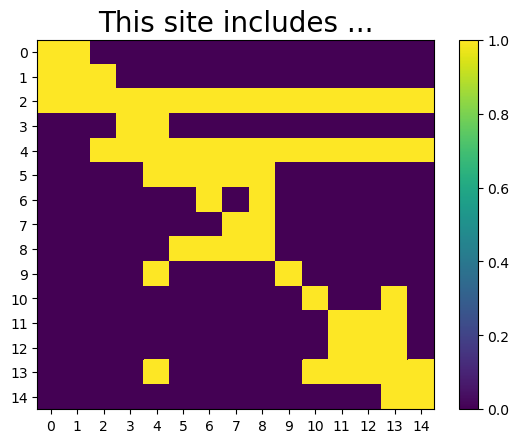

In [32]:
# Assuming 'tokens' is already defined as a DataFrame or array

df = pd.DataFrame(ed.loc[0].encoder_attention_mask[:15,:15])

plt.pcolor(df)
plt.xticks(np.arange(0.5, len(df.columns), 1), df.columns)
plt.yticks(np.arange(0.5, len(df.index), 1), df.index)
plt.gca().invert_yaxis()  # Invert the y-axis to move (0,0) to the upper left
plt.title('This site includes ...', fontsize=20)
# plt.xlabel('Year', fontsize=14)
# plt.ylabel('Month', fontsize=14)
plt.colorbar()
plt.show()